In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_formats = ["svg"]
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 5
plt.rcParams["pdf.fonttype"] = 42

Load analyzed nuclei data for each slide:

In [2]:
def load_data(folder, root="images"):
    data = pd.read_excel(os.path.join(root, folder, "results", "data.xlsx"), index_col=0)
    return data

In [3]:
samples = [
    "NIID1_skin",
    "FXTAS5006_P",
    "FXTAS5006_CB",
    "FXTAS5006_BA8",
    "FXTAS5006_BA24",
    "FXTAS5746_P",
    "FXTAS5746_CB",
    "FXTAS5746_BA8",
    "FXTAS5746_BA24",
    "FXTAS4555_P",
    "FXTAS4555_CB",
    "FXTAS4555_BA8",
    "FXTAS4555_BA24",
    "cell_block_A1",
    "cell_block_A2",
    "FXTAS5006_CB-RTCB",
    "FXTAS5006_CB-DDX1",
    "FXTAS5006_CB-RTRAF",
    "FXTAS5006_CB-p62",
]
data = {}
for s in samples:
    data[s] = load_data(s)
    print(s)

NIID1_skin
FXTAS5006_P
FXTAS5006_CB
FXTAS5006_BA8
FXTAS5006_BA24
FXTAS5746_P
FXTAS5746_CB
FXTAS5746_BA8
FXTAS5746_BA24
FXTAS4555_P
FXTAS4555_CB
FXTAS4555_BA8
FXTAS4555_BA24
cell_block_A1
cell_block_A2
FXTAS5006_CB-RTCB
FXTAS5006_CB-DDX1
FXTAS5006_CB-RTRAF
FXTAS5006_CB-p62


Perform background subtraction based on background ROIs:

In [4]:
# same background value for entire slide
background = {}
for s, df in data.items():
    for i in set(df["roi"]):
        background[s, i] = pd.read_csv(
            os.path.join("images", s, "background", "roi0.txt"), sep="\t", skiprows=1
        )["Mean Intensity (AF647)"].mean()
for s, df in data.items():
    df["background"] = df["roi"].map(lambda i: background[s, i])

# write post-processed table to data2.xlsx
for s, df in data.items():
    df.to_excel(os.path.join("images", s, "results", "data2.xlsx"))

Analyze HA/FAM98B FFPE cell blocks for Fig. S6C:

In [5]:
cellblock_samples = {
    "cell_block_A1",
    "cell_block_A2"
}
cellblock_names = {
    "cell_block_A1": "FAM98B (Proteintech)",
    "cell_block_A2": "FAM98B (Atlas)"
}
data = {s: df for s, df in data.items() if s in cellblock_samples}

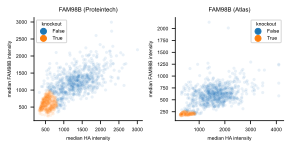

In [6]:
from sklearn.mixture import GaussianMixture

fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, (s, df) in zip(axs, data.items()):
    # quartiles-1_ch1 is the median HA intensity
    # quartiles-1 is the median FAM98B intensity
    gm = GaussianMixture(n_components=2).fit(
        df[["quartiles-1_ch1", "quartiles-1"]].values
    )
    # KO cluster is the one with lower median FAM98B intensity
    label_ko = np.argmin(gm.means_[:, 0])
    predictions = gm.predict(df[["quartiles-1_ch1", "quartiles-1"]].values)
    df["knockout"] = predictions == label_ko

    sns.scatterplot(
        data=df,
        x="quartiles-1_ch1",
        y="quartiles-1",
        hue="knockout",
        alpha=0.1,
        ax=ax,
        s=10,
    )
    sns.despine()
    ax.set_title(cellblock_names[s])
    ax.set_xlabel("median HA intensity")
    ax.set_ylabel("median FAM98B intensity")

plt.tight_layout()

In [7]:
# write post-processed table to data2.xlsx
for s, df in data.items():
    df.to_excel(os.path.join("images", s, "results", "data2.xlsx"))